In [1]:
# 1- Install the torchmetrics package for storing loss, evaluation metrics. etc

!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install torchvision
!pip install torchinfo --no-deps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms  
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
import torch.optim as optim

In [3]:
from torchvision.transforms import v2

In [5]:
# 2- Define transforms - (Data Augmentation)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

In [7]:
# 3- Obtain the CIFAR10 dataset for the training data part with 50,000 images

train_data = torchvision.datasets.CIFAR10(root= "./data" , train = True, download = True, transform=train_transform)



# Obtain the CIFAR10 dataset for the testing data part with 10,000 images

test_data = torchvision.datasets.CIFAR10(root= "./data" , train = False, download = True, transform=test_transform)

In [9]:
# 4- Perform train, validation, and test split.

train_set, val_set = torch.utils.data.random_split(train_data, [40000, 10000])

# Apply test_transform to validation set as well

val_set.dataset.transform = test_transform
print("number of train samples:", len(train_set))
print("number of validation samples:", len(val_set))
print("number of test samples:", len(test_data))

number of train samples: 40000
number of validation samples: 10000
number of test samples: 10000


In [11]:
# 5- Prepare for mini-batch data loading using DataLoader.

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False)


In [13]:
# 6- Build a convolutional neural network (CNN) model.

model = nn.Sequential(
    nn.LazyConv2d(32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)

In [15]:
# 7- Move the model to device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# 8- Set the loss function as the cross entropy (CE) loss

criteria = torch.nn.CrossEntropyLoss()

In [19]:
# 9- Set the optimizer to stochastic gradient descent (SGD)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# 11- Perform training and evaluation, and loss and accuracy.

def train_one_epoch():
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=10).to(device)
  model.train() # set model to train mode
  # a loop to iterate input(X) and label(Y) for all mini-batches
  for X, Y in train_dataloader:
    X = X.to(device) # move input (X) to GPU device
    Y = Y.to(device) # move disired output (Y) to GPU device
    optimizer.zero_grad() # reset optimizer
    preds = model(X) # model forward
    loss = criteria(preds, Y) # calculate loss
    loss.backward() # compute gradients via backpropagation
    optimizer.step() # perform gradient descent
    preds = preds.argmax(dim=1) # obtain the final predicted class
    losses.update(loss, X.size(0)) # store loss per batch
    acc.update(preds, Y) # store accuracy per batch
  # return loss and accuracy for the epoch
  return losses.compute().item(), acc.compute().item()



In [23]:
# a function for validation one epoch
def validation_one_epoch():
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=10).to(device)
  model.eval() # set model to validation mode
  # a loop to iterate input(X) and label(Y) for all mini-batches
  for X, Y in val_dataloader:
    X = X.to(device) # move input (X) to GPU device
    Y = Y.to(device) # move disired output (Y) to GPU device
    preds = model(X) # model forward
    loss = criteria(preds, Y) # calculate loss
    preds = preds.argmax(dim=1) # obtain the final predicted class
    losses.update(loss, X.size(0)) # store loss per batch
    acc.update(preds, Y) # store accuracy per batch
    # return loss and accuracy for the epoch
  return losses.compute().item(), acc.compute().item()

In [25]:
# Prepare for storing loss and accuracy
history = pd.DataFrame() # store statics for each epoch


In [27]:
epochs = 10 # number of epochs

# a loop for epochs

for i in range(0, epochs):
  train_loss, train_acc = train_one_epoch() # training
  val_loss, val_acc = validation_one_epoch() # validation
  print("Epoch:", i, "| Train Loss:", train_loss, "| Train Accuracy", train_acc, "| Validation Loss", val_loss, "| Validation Accuracy", val_acc)
  statistics = pd.DataFrame({
  "epoch": [i], "train_loss": [train_loss],
  "train_acc": [train_acc],
  "val_loss": [val_loss],
  "val_acc": [val_acc]})
  history = pd.concat([history, statistics], ignore_index=True)

Epoch: 0 | Train Loss: 1.7168941497802734 | Train Accuracy 0.3727250099182129 | Validation Loss 1.480593204498291 | Validation Accuracy 0.45559999346733093
Epoch: 1 | Train Loss: 1.3063139915466309 | Train Accuracy 0.5300750136375427 | Validation Loss 1.2676618099212646 | Validation Accuracy 0.5432999730110168
Epoch: 2 | Train Loss: 1.1243631839752197 | Train Accuracy 0.5982499718666077 | Validation Loss 1.0925322771072388 | Validation Accuracy 0.6100999712944031
Epoch: 3 | Train Loss: 0.9857780337333679 | Train Accuracy 0.6517999768257141 | Validation Loss 1.062186598777771 | Validation Accuracy 0.619700014591217
Epoch: 4 | Train Loss: 0.8935702443122864 | Train Accuracy 0.6844750046730042 | Validation Loss 0.967049241065979 | Validation Accuracy 0.6553999781608582
Epoch: 5 | Train Loss: 0.8024008870124817 | Train Accuracy 0.7160999774932861 | Validation Loss 0.9187069535255432 | Validation Accuracy 0.6765000224113464
Epoch: 6 | Train Loss: 0.7158095240592957 | Train Accuracy 0.748650

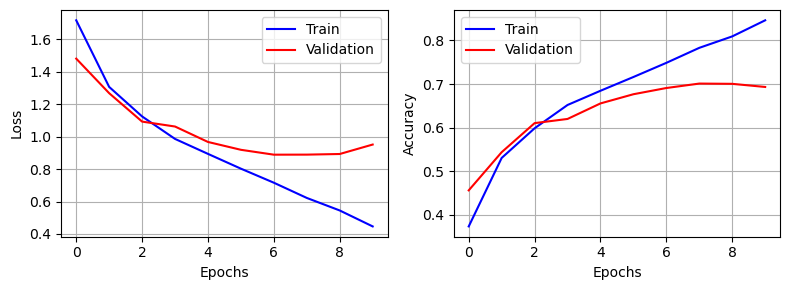

In [29]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train",
color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation",
color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train",
color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation",
color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()